In [ ]:
import pandas as pd
import random
import os
from collections import defaultdict
from tqdm import tqdm

# Load existing positive pairs
input_file = 'input_pairs.csv'
df_pos = pd.read_csv(input_file)

# Extract unique filenames by dataset
dataset_map = defaultdict(list)

# Group images by dataset
for col in ['img1', 'img2']:
    for filename in df_pos[col]:
        if 'lfw' in filename.lower():
            dataset = 'LFW'
        elif 'vggface2' in filename.lower():
            dataset = 'VGGFace2'
        elif 'celeba' in filename.lower():
            dataset = 'CelebA'
        else:
            continue  # Unknown dataset
        dataset_map[dataset].append(filename)

# Deduplicate filenames
for dataset in dataset_map:
    dataset_map[dataset] = list(set(dataset_map[dataset]))

# Helper to extract identity from filename
def get_identity(filename, dataset):
    if dataset == 'LFW':
        return filename.split('/')[1]  # e.g., lfw/Aaron_Eckhart/...
    elif dataset == 'VGGFace2':
        return filename.split('/')[1]  # e.g., vggface2/n000002/...
    elif dataset == 'CelebA':
        return filename.split('/')[-1].split('.')[0].split('_')[0]  # You can modify based on actual filename
    return None

# Generate 5181 negative pairs (same dataset, different identity)
negative_pairs = []

random.seed(42)
print("Generating negative pairs...")

for dataset in dataset_map:
    img_list = dataset_map[dataset]
    identity_to_imgs = defaultdict(list)

    for img in img_list:
        identity = get_identity(img, dataset)
        if identity:
            identity_to_imgs[identity].append(img)

    identities = list(identity_to_imgs.keys())

    while len(negative_pairs) < 5181:
        id1, id2 = random.sample(identities, 2)
        img1 = random.choice(identity_to_imgs[id1])
        img2 = random.choice(identity_to_imgs[id2])
        negative_pairs.append([img1, img2, 'impersonation_attack'])

        if len(negative_pairs) % 500 == 0:
            print(f"{len(negative_pairs)} negative pairs generated...")

# Create dataframe
df_neg = pd.DataFrame(negative_pairs, columns=['img1', 'img2', 'attack_type'])

# Combine with original positive pairs (assumed to have 'attack_type' column)
df_combined = pd.concat([df_pos, df_neg], ignore_index=True)
df_combined.to_csv('extended_input_pairs.csv', index=False)
print("✅ Extended dataset saved to 'extended_input_pairs.csv'")


Generating negative pairs...
500 negative pairs generated...
1000 negative pairs generated...
1500 negative pairs generated...
2000 negative pairs generated...
2500 negative pairs generated...
3000 negative pairs generated...
3500 negative pairs generated...
4000 negative pairs generated...
4500 negative pairs generated...
5000 negative pairs generated...
✅ Extended dataset saved to 'extended_input_pairs.csv'


In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
!pip install deepface

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.6/108.6 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 34.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 48.8 MB/s eta 0:00:00
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114249 sha256=8b750aacb57af504f02a40c42be05a6fe3f32f0cdb52d85ffef03e063eca76d8
  Stored in directory: /root/.cache/pip/wheels/46/54/24/1624fd5b8674eb1188623f7e8e17cdf7c0f6c24b609dfb8a89
Successfully built fire


In [ ]:
!pip install tensorflow==2.12.0

INFO: pip is looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 586.0/586.0 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 54.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 58.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 51.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 84.9 MB/s eta 0:00:00
 

In [ ]:
!pip install pandas numpy pillow tqdm


In [ ]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from deepface import DeepFace
import tensorflow as tf

# === Model Configuration ===
MODELS = {
    "VGG-Face": {"target_size": (224, 224)},
    "Facenet": {"target_size": (160, 160)},
    "Facenet512": {"target_size": (160, 160)},
    "OpenFace": {"target_size": (96, 96)},
    "ArcFace": {"target_size": (112, 112)},
}

# === Optimized Embedding Extraction ===
def get_embedding(img_path, model_name):
    try:
        embedding = DeepFace.represent(
            img_path=img_path,
            model_name=model_name,
            enforce_detection=False,
            detector_backend="skip",
            align=False
        )
        return embedding[0]["embedding"]
    except Exception as e:
        print(f"Error in {model_name} for {img_path}: {str(e)[:100]}...")
        return None

# === Batch Processing with Progress ===
def process_dataset(input_csv, output_csv, dataset_root):
    df = pd.read_csv(input_csv)
    results = []

    # Pre-build all models to cache them
    print("Building models...")
    for model_name in MODELS.keys():
        DeepFace.build_model(model_name)

    for _, row in tqdm(df.iterrows(), total=len(df)):
        img1_path = os.path.join(dataset_root, row['img1'])
        img2_path = os.path.join(dataset_root, row['img2'])

        if not all(os.path.exists(p) for p in [img1_path, img2_path]):
            continue

        record = {"img1": row['img1'], "img2": row['img2']}

        for model_name in MODELS.keys():
            # Get both embeddings first
            emb1 = get_embedding(img1_path, model_name)
            emb2 = get_embedding(img2_path, model_name)

            # Compute similarity if both embeddings exist
            if emb1 is not None and emb2 is not None:
                emb1 = np.array(emb1)
                emb2 = np.array(emb2)
                cos_sim = np.dot(emb1, emb2) / (np.linalg.norm(emb1) * np.linalg.norm(emb2))
                record[model_name] = float(cos_sim)
            else:
                record[model_name] = -1

        results.append(record)

    pd.DataFrame(results).to_csv(output_csv, index=False)

# === Execution ===
if __name__ == "__main__":
    # Verify environment
    print(f"TensorFlow version: {tf.__version__}")
    print(f"DeepFace version: {DeepFace.__version__}")

    process_dataset(
        input_csv="input_pairs.csv",
        output_csv="final_results.csv",
        dataset_root="/content/drive/MyDrive/dataset_extractedfaces"
    )

TensorFlow version: 2.12.0
DeepFace version: 0.0.93
Building models...
25-05-31 10:43:56 - arcface_weights.h5 will be downloaded to /root/.deepface/weights/arcface_weights.h5


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/arcface_weights.h5
To: /root/.deepface/weights/arcface_weights.h5
100%|██████████| 137M/137M [00:00<00:00, 198MB/s]
 84%|████████▍ | 6399/7640 [7:19:07<1:31:22,  4.42s/it]

In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from PIL import Image
from tqdm import tqdm
from deepface import DeepFace

# === Only include remaining models to process ===
remaining_models = {
    "DeepFace": (152, 152),  # Requires TF <= 2.12
    "DeepID": (47, 55),
    "GhostFaceNet": (112, 112),
}

# === Image Preprocessing ===
def load_and_preprocess(image_path, input_size):
    img = Image.open(image_path).convert('RGB').resize(input_size)
    return np.array(img)  # DeepFace handles normalization internally

# === Embedding Computation ===
def compute_embedding(image_path, model_name):
    # Use DeepFace's represent function directly
    embedding_objs = DeepFace.represent(
        img_path=image_path,
        model_name=model_name,
        enforce_detection=False,
        detector_backend="skip",  # Skip face detection for faster processing
        align=False  # Skip alignment for pre-cropped faces
    )
    return tf.convert_to_tensor(embedding_objs[0]["embedding"])

# === Cosine Similarity ===
def cosine_similarity(emb1, emb2):
    emb1 = tf.nn.l2_normalize(emb1, axis=-1)
    emb2 = tf.nn.l2_normalize(emb2, axis=-1)
    cos_sim = tf.reduce_sum(emb1 * emb2).numpy()
    return float((cos_sim + 1.0) / 2.0)

# === Batch Processing for Remaining Models ===
def evaluate_remaining_models(input_file, dataset_root, output_file):
    # Load existing results
    existing_results = pd.read_csv(output_file)

    # Create a copy to modify
    results = existing_results.copy()

    # Get pairs that haven't been processed for these models
    pairs = pd.read_csv(input_file)

    for _, row in tqdm(pairs.iterrows(), total=len(pairs)):
        img1_path = os.path.join(dataset_root, row['img1'])
        img2_path = os.path.join(dataset_root, row['img2'])

        # Skip if file doesn't exist
        if not os.path.exists(img1_path) or not os.path.exists(img2_path):
            continue

        # Find the existing result row
        result_idx = results[(results['img1'] == row['img1']) &
                           (results['img2'] == row['img2'])].index

        if len(result_idx) == 0:
            # Create new row if doesn't exist
            new_row = {'dataset': '', 'img1': row['img1'], 'img2': row['img2']}
            # Initialize all model columns with -1
            for model in remaining_models:
                new_row[model] = -1
            results = pd.concat([results, pd.DataFrame([new_row])], ignore_index=True)
            result_idx = [len(results)-1]

        for model_name, input_size in remaining_models.items():
            # Skip if this model already has a result
            if not pd.isna(results.loc[result_idx[0], model_name]):
                continue

            try:
                # Skip DeepFace on incompatible TF versions
                if model_name == "DeepFace" and int(tf.__version__.split('.')[1]) > 12:
                    raise RuntimeError("DeepFace model not supported in TF > 2.12")

                # Compute embeddings
                emb1 = compute_embedding(img1_path, model_name)
                emb2 = compute_embedding(img2_path, model_name)

                sim = cosine_similarity(emb1, emb2)
                results.at[result_idx[0], model_name] = sim
            except Exception as e:
                print(f"Error processing {img1_path} and {img2_path} for {model_name}: {e}")
                results.at[result_idx[0], model_name] = -1

    # Save updated results
    results.to_csv(output_file, index=False)
    print(f"\nUpdated results with remaining models saved to {output_file}")

# === Run Evaluation for Remaining Models ===
input_file = 'input_pairs.csv'  # CSV with 'img1' and 'img2' columns
dataset_root = '/content/drive/MyDrive/dataset_extractedfaces'
output_file = 'cosine_original_similarities.csv'  # Existing results file

evaluate_remaining_models(input_file, dataset_root, output_file)

In [ ]:
# Import required libraries
import os
import numpy as np
import tensorflow as tf
from PIL import Image
from deepface import DeepFace

# Preprocessing function for image loading and resizing
def load_and_preprocess(image_path, input_size):
    """
    Loads and preprocesses the image to the required format.

    Args:
    - image_path (str): Path to the image to be processed.
    - input_size (tuple): Desired image size for model input.

    Returns:
    - np.array: Preprocessed image tensor.
    """
    img = Image.open(image_path).convert('RGB').resize(input_size)  # Open, convert and resize image
    arr = np.array(img).astype('float32') / 255.0  # Convert to numpy array and normalize to [0, 1]
    return (arr - 0.5) * 2  # Scale to [-1, 1]

# Compute embeddings by passing the image through the model
def compute_embedding(model, image_tensor):
    """
    Computes the normalized embedding (feature vector) of an image.

    Args:
    - model (tf.Model): The deep learning model used for generating embeddings.
    - image_tensor (tf.Tensor): The image tensor to be processed.

    Returns:
    - tf.Tensor: The normalized embedding vector.
    """
    return tf.nn.l2_normalize(model(image_tensor, training=False), axis=1)

# Load embedding from an image file path
def load_embedding(image_path, model, input_size):
    """
    Loads and processes the image to get its embedding using the provided model.

    Args:
    - image_path (str): Path to the image.
    - model (tf.Model): The model used for generating the embedding.
    - input_size (tuple): The size required by the model.

    Returns:
    - tf.Tensor: The image embedding.
    """
    img_tensor = tf.expand_dims(load_and_preprocess(image_path, input_size), 0)  # Add batch dimension
    return compute_embedding(model, img_tensor)  # Compute the embedding

# Compute cosine similarity between two embeddings
def cosine_similarity(emb1, emb2):
    """
    Computes normalized cosine similarity between two embeddings in the range [0, 1].

    Args:
    - emb1 (tf.Tensor): First embedding tensor.
    - emb2 (tf.Tensor): Second embedding tensor.

    Returns:
    - float: Cosine similarity normalized to [0, 1].
    """
    emb1 = tf.nn.l2_normalize(emb1, axis=-1)
    emb2 = tf.nn.l2_normalize(emb2, axis=-1)
    cos_sim = tf.reduce_sum(emb1 * emb2).numpy()
    norm_sim = (cos_sim + 1.0) / 2.0
    return float(norm_sim)


# Main function to process the images and calculate similarities
def main(img1_path, img2_path, adv_path):
    """
    Function to load face images, preprocess them, compute embeddings for each,
    and calculate the cosine similarities between the original and adversarial images
    using different face recognition models.

    Args:
    - img1_path (str): Path to the first image (e.g., a real image of a person).
    - img2_path (str): Path to the second image (e.g., a different image of the same person).
    - adv_path (str): Path to the adversarial image (image generated to impersonate).

    Returns:
    - None
    """
    # === DeepFace model names and expected input sizes ===
    deepface_models = {
        "VGG-Face": (224, 224),
        "Facenet": (160, 160),
        "Facenet512": (160, 160),
        "OpenFace": (96, 96),
        "DeepFace": (152, 152),
        "DeepID": (47, 55),
        "ArcFace": (112, 112),
        "GhostFaceNet": (112, 112),
    }

    # Loop through each model in the deepface_models dictionary
    for model_name, input_size in deepface_models.items():
        print(f"\n=== Processing with model: {model_name} ===")

        try:
            # Build the model using DeepFace
            model = DeepFace.build_model(model_name).model

            # Compute embeddings for the three images
            emb1 = load_embedding(img1_path, model, input_size)
            emb2 = load_embedding(img2_path, model, input_size)
            emb_adv = load_embedding(adv_path, model, input_size)

            # Compute cosine similarities for the original and adversarial images
            original_sim = cosine_similarity(emb1, emb2)
            adversarial_sim = cosine_similarity(emb_adv, emb2)

            # Print out the similarities
            print(f"Original Similarity (img1 vs img2): {original_sim:.4f}")
            print(f"Adversarial Similarity (adv vs img2): {adversarial_sim:.4f}")

            print(f"Failed on {model_name}: {str(e)}")

def generate_random_image(path, size=(224, 224)):
    """
    Generates and saves a random RGB image at the given path.

    Args:
    - path (str): Path where the image will be saved.
    - size (tuple): Image size in (width, height).
    """
    array = np.random.randint(0, 256, (size[1], size[0], 3), dtype=np.uint8)
    img = Image.fromarray(array)
    img.save(path)

# Generate and save random images for testing
generate_random_image("rand_img1.jpg", (224, 224))
generate_random_image("rand_img2.jpg", (224, 224))
generate_random_image("rand_adv.jpg", (224, 224))

# Run main using random images
main("rand_img1.jpg", "rand_img2.jpg", "rand_adv.jpg")



SyntaxError: expected 'except' or 'finally' block (<ipython-input-3-82b06ab80c96>, line 123)

In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from PIL import Image
from deepface import DeepFace
import logging

# Configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Preprocessing function for image loading and resizing
def load_and_preprocess(image_path, input_size):
    try:
        img = Image.open(image_path).convert('RGB').resize(input_size)
        arr = np.array(img).astype('float32') / 255.0
        return (arr - 0.5) * 2  # Scale to [-1, 1]
    except Exception as e:
        logger.error(f"Error loading {image_path}: {str(e)}")
        return None

# Compute embeddings by passing the image through the model
def compute_embedding(model, image_tensor):
    try:
        if image_tensor is None:
            return None
        return tf.nn.l2_normalize(model(image_tensor, training=False), axis=1)
    except Exception as e:
        logger.error(f"Error computing embedding: {str(e)}")
        return None

# Load embedding from an image file path
def load_embedding(image_path, model, input_size):
    try:
        img_array = load_and_preprocess(image_path, input_size)
        if img_array is None:
            return None
        img_tensor = tf.expand_dims(img_array, 0)  # Add batch dimension
        return compute_embedding(model, img_tensor)
    except Exception as e:
        logger.error(f"Error loading embedding for {image_path}: {str(e)}")
        return None

# Compute cosine similarity between two embeddings
def cosine_similarity(emb1, emb2):
    try:
        if emb1 is None or emb2 is None:
            return np.nan

        # Convert to tensors if they're numpy arrays
        if isinstance(emb1, np.ndarray):
            emb1 = tf.convert_to_tensor(emb1)
        if isinstance(emb2, np.ndarray):
            emb2 = tf.convert_to_tensor(emb2)

        emb1 = tf.nn.l2_normalize(emb1, axis=-1)
        emb2 = tf.nn.l2_normalize(emb2, axis=-1)
        cos_sim = tf.reduce_sum(emb1 * emb2).numpy()
        norm_sim = (cos_sim + 1.0) / 2.0
        return float(norm_sim)
    except Exception as e:
        logger.error(f"Error calculating cosine similarity: {str(e)}")
        return np.nan

def calculate_similarities_for_pairs(input_csv, output_csv):
    """
    Calculate cosine similarities for positive and negative face pairs using various DeepFace models.

    Args:
    - input_csv (str): Path to input CSV file containing image pairs
    - output_csv (str): Path to output CSV file for storing similarities
    """
    # Define models and their input sizes
    models = {
        "VGG-Face": (224, 224),
        "Facenet": (160, 160),
        "Facenet512": (160, 160),
        "ArcFace": (112, 112),
        "GhostFaceNet": (112, 112),
        "SFace": (112, 112),
        "Dlib": (150, 150),
        "Buffalo_s": (112, 112)
    }

    # Read input pairs
    try:
        df_pairs = pd.read_csv(input_csv)
        total_pairs = len(df_pairs)
        logger.info(f"Loaded {total_pairs} pairs from {input_csv}")
    except Exception as e:
        logger.error(f"Error reading input CSV: {str(e)}")
        return

    # Initialize results dataframe with correct column order
    model_names = list(models.keys())
    results = pd.DataFrame(columns=model_names)

    # Pre-initialize results with NaNs
    for col in model_names:
        results[col] = [np.nan] * total_pairs

    # Process each model
    for model_name, input_size in models.items():
        logger.info(f"\nProcessing model: {model_name}")

        try:
            # Build the model
            if model_name == "Buffalo_s":
                # Buffalo_s is handled by the ArcFace model in DeepFace
                model = DeepFace.build_model("ArcFace")
            else:
                model = DeepFace.build_model(model_name)

            # Process each pair
            for idx, row in df_pairs.iterrows():
                img1_path = row['img1_path']
                img2_path = row['img2_path']

                try:
                    # Compute embeddings
                    emb1 = load_embedding(img1_path, model, input_size)
                    emb2 = load_embedding(img2_path, model, input_size)

                    # Calculate similarity
                    if emb1 is not None and emb2 is not None:
                        sim = cosine_similarity(emb1, emb2)
                        results.at[idx, model_name] = sim

                except Exception as e:
                    logger.error(f"Error processing pair {idx+1} with model {model_name}: {str(e)}")

                # Print progress
                if (idx + 1) % 100 == 0:
                    logger.info(f"Processed {idx+1}/{total_pairs} pairs for {model_name}")

            logger.info(f"Completed processing for {model_name}")

        except Exception as e:
            logger.error(f"Error initializing model {model_name}: {str(e)}")

    # Add dataset column (assuming first half is positive, second half is negative)
    results['dataset'] = ['positive'] * 4500 + ['negative'] * 4500

    # Save results
    try:
        results.to_csv(output_csv, index=False)
        logger.info(f"\nSaved results to {output_csv}")
    except Exception as e:
        logger.error(f"Error saving results: {str(e)}")

# Example usage
if __name__ == "__main__":
    # You'll need to have 'input_pairs.csv' with columns: img1_path, img2_path
    calculate_similarities_for_pairs("input_pairs.csv", "cosine_original_similarities_name.csv")

25-06-01 04:04:03 - Directory /root/.deepface has been created
25-06-01 04:04:03 - Directory /root/.deepface/weights has been created
25-06-01 04:04:06 - vgg_face_weights.h5 will be downloaded...


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/vgg_face_weights.h5
To: /root/.deepface/weights/vgg_face_weights.h5
100%|██████████| 580M/580M [00:06<00:00, 91.6MB/s]
ERROR:__main__:Error initializing model VGG-Face: 'img1_path'


25-06-01 04:04:16 - facenet_weights.h5 will be downloaded...


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/facenet_weights.h5
To: /root/.deepface/weights/facenet_weights.h5
100%|██████████| 92.2M/92.2M [00:00<00:00, 233MB/s]
ERROR:__main__:Error initializing model Facenet: 'img1_path'
Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/facenet512_weights.h5
To: /root/.deepface/weights/facenet512_weights.h5


25-06-01 04:04:21 - facenet512_weights.h5 will be downloaded...


100%|██████████| 95.0M/95.0M [00:00<00:00, 203MB/s]
ERROR:__main__:Error initializing model Facenet512: 'img1_path'


25-06-01 04:04:25 - arcface_weights.h5 will be downloaded to /root/.deepface/weights/arcface_weights.h5


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/arcface_weights.h5
To: /root/.deepface/weights/arcface_weights.h5
100%|██████████| 137M/137M [00:00<00:00, 254MB/s]
ERROR:__main__:Error initializing model ArcFace: 'img1_path'


25-06-01 04:04:30 - Pre-trained weights is downloaded from https://github.com/HamadYA/GhostFaceNets/releases/download/v1.2/GhostFaceNet_W1.3_S1_ArcFace.h5 to /root/.deepface/weights/ghostfacenet_v1.h5


Downloading...
From: https://github.com/HamadYA/GhostFaceNets/releases/download/v1.2/GhostFaceNet_W1.3_S1_ArcFace.h5
To: /root/.deepface/weights/ghostfacenet_v1.h5
100%|██████████| 17.3M/17.3M [00:00<00:00, 44.5MB/s]


25-06-01 04:04:31 - Pre-trained weights is just downloaded to /root/.deepface/weights/ghostfacenet_v1.h5


ERROR:__main__:Error initializing model GhostFaceNet: 'img1_path'


25-06-01 04:04:31 - face_recognition_sface_2021dec.onnx weights will be downloaded...


Downloading...
From: https://github.com/opencv/opencv_zoo/raw/main/models/face_recognition_sface/face_recognition_sface_2021dec.onnx
To: /root/.deepface/weights/face_recognition_sface_2021dec.onnx
100%|██████████| 38.7M/38.7M [00:00<00:00, 203MB/s] 
ERROR:__main__:Error initializing model SFace: 'img1_path'


25-06-01 04:04:33 - dlib_face_recognition_resnet_model_v1.dat is going to be downloaded


Downloading...
From: http://dlib.net/files/dlib_face_recognition_resnet_model_v1.dat.bz2
To: /root/.deepface/weights/dlib_face_recognition_resnet_model_v1.dat.bz2
100%|██████████| 21.4M/21.4M [00:00<00:00, 28.4MB/s]
ERROR:__main__:Error initializing model Dlib: Error while calling cudaGetDevice(&the_device_id) in file /tmp/.tmpjoMjdV/sdists-v9/pypi/dlib/19.24.6/Qzeo02mYNXxZn_2N9ccJq/src/dlib/cuda/gpu_data.cpp:204. code: 35, reason: CUDA driver version is insufficient for CUDA runtime version
ERROR:__main__:Error initializing model Buffalo_s: 'img1_path'


ValueError: Length of values (9000) does not match length of index (7640)

In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from PIL import Image
from deepface import DeepFace

# Preprocessing function for image loading and resizing
def load_and_preprocess(image_path, input_size):
    """
    Loads and preprocesses the image to the required format.

    Args:
    - image_path (str): Path to the image to be processed.
    - input_size (tuple): Desired image size for model input.

    Returns:
    - np.array: Preprocessed image tensor.
    """
    img = Image.open(image_path).convert('RGB').resize(input_size)  # Open, convert and resize image
    arr = np.array(img).astype('float32') / 255.0  # Convert to numpy array and normalize to [0, 1]
    return (arr - 0.5) * 2  # Scale to [-1, 1]

# Compute embeddings by passing the image through the model
def compute_embedding(model, image_tensor):
    """
    Computes the normalized embedding (feature vector) of an image.

    Args:
    - model (tf.Model): The deep learning model used for generating embeddings.
    - image_tensor (tf.Tensor): The image tensor to be processed.

    Returns:
    - tf.Tensor: The normalized embedding vector.
    """
    return tf.nn.l2_normalize(model(image_tensor, training=False), axis=1)

# Load embedding from an image file path
def load_embedding(image_path, model, input_size):
    """
    Loads and processes the image to get its embedding using the provided model.

    Args:
    - image_path (str): Path to the image.
    - model (tf.Model): The model used for generating the embedding.
    - input_size (tuple): The size required by the model.

    Returns:
    - tf.Tensor: The image embedding.
    """
    img_tensor = tf.expand_dims(load_and_preprocess(image_path, input_size), 0)  # Add batch dimension
    return compute_embedding(model, img_tensor)  # Compute the embedding

# Compute cosine similarity between two embeddings
def cosine_similarity(emb1, emb2):
    """
    Computes normalized cosine similarity between two embeddings in the range [0, 1].

    Args:
    - emb1 (tf.Tensor): First embedding tensor.
    - emb2 (tf.Tensor): Second embedding tensor.

    Returns:
    - float: Cosine similarity normalized to [0, 1].
    """
    emb1 = tf.nn.l2_normalize(emb1, axis=-1)
    emb2 = tf.nn.l2_normalize(emb2, axis=-1)
    cos_sim = tf.reduce_sum(emb1 * emb2).numpy()
    norm_sim = (cos_sim + 1.0) / 2.0
    return float(norm_sim)

def calculate_similarities_for_pairs(input_csv, output_csv):
    """
    Calculate cosine similarities for positive and negative face pairs using various DeepFace models.

    Args:
    - input_csv (str): Path to input CSV file containing image pairs
    - output_csv (str): Path to output CSV file for storing similarities
    """
    # Define models and their input sizes
    models = {
        "VGG-Face": (224, 224),
        "Facenet": (160, 160),
        "Facenet512": (160, 160),
        "ArcFace": (112, 112),
        "GhostFaceNet": (112, 112),
        "SFace": (112, 112),
        "Dlib": (150, 150),
        "Buffalo_s": (112, 112)
    }

    # Read input pairs
    df_pairs = pd.read_csv(input_csv)
    total_pairs = len(df_pairs)

    # Initialize results dataframe
    results = pd.DataFrame(columns=list(models.keys()))

    # Process each model
    for model_name, input_size in models.items():
        print(f"\nProcessing model: {model_name}")

        try:
            # Build the model
            model = DeepFace.build_model(model_name).model

            # Initialize similarities list for this model
            similarities = []

            # Process each pair
            for idx, row in df_pairs.iterrows():
                img1_path = row['img1']
                img2_path = row['img2']

                try:
                    # Compute embeddings
                    emb1 = load_embedding(img1_path, model, input_size)
                    emb2 = load_embedding(img2_path, model, input_size)

                    # Calculate similarity
                    sim = cosine_similarity(emb1, emb2)
                    similarities.append(sim)

                except Exception as e:
                    print(f"Error processing pair {idx+1} with model {model_name}: {str(e)}")
                    similarities.append(np.nan)

                # Print progress
                if (idx + 1) % 100 == 0:
                    print(f"Processed {idx+1}/{total_pairs} pairs")

            # Add to results
            results[model_name] = similarities

        except Exception as e:
            print(f"Error initializing model {model_name}: {str(e)}")
            results[model_name] = [np.nan] * total_pairs

    # Add dataset column (assuming first half is positive, second half is negative)
    results['dataset'] = ['positive'] * 4500 + ['negative'] * 4500

    # Save results
    results.to_csv(output_csv, index=False)
    print(f"\nSaved results to {output_csv}")

# Example usage
if __name__ == "__main__":
    # You'll need to have 'input_pairs.csv' with columns: img1_path, img2_path
    calculate_similarities_for_pairs("input_pairs.csv", "cosine_original_similarities_name.csv")


Processing model: VGG-Face
Error initializing model VGG-Face: 'img1_path'

Processing model: Facenet
Error initializing model Facenet: 'img1_path'

Processing model: Facenet512
Error initializing model Facenet512: 'img1_path'

Processing model: ArcFace
Error initializing model ArcFace: 'img1_path'

Processing model: GhostFaceNet
Error initializing model GhostFaceNet: 'img1_path'

Processing model: SFace
Error initializing model SFace: 'img1_path'

Processing model: Dlib
Error initializing model Dlib: Error while calling cudaGetDevice(&the_device_id) in file /tmp/.tmpjoMjdV/sdists-v9/pypi/dlib/19.24.6/Qzeo02mYNXxZn_2N9ccJq/src/dlib/cuda/gpu_data.cpp:204. code: 35, reason: CUDA driver version is insufficient for CUDA runtime version

Processing model: Buffalo_s
Error initializing model Buffalo_s: Invalid model_name passed - facial_recognition/Buffalo_s


ValueError: Length of values (9000) does not match length of index (7640)

In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from PIL import Image
from deepface import DeepFace
import logging
import sys
from keras import backend as K

# ====================== LOGGING SETUP ======================
# Configure logging to show in Colab output and save to file
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s [%(levelname)s] %(message)s',
    handlers=[
        logging.StreamHandler(sys.stdout),  # Show in Colab
        logging.FileHandler('cosine_similarity.log')  # Save to file
    ]
)
logger = logging.getLogger(__name__)
logger.info("Logger initialized - output will show here in Colab")

# ====================== CORE FUNCTIONS ======================
def load_and_preprocess(image_path, input_size):
    try:
        full_path = os.path.join(BASE_IMAGE_DIR, image_path)
        if not os.path.exists(full_path):
            logger.error(f"Image not found: {full_path}")
            return None

        img = Image.open(full_path).convert('RGB').resize(input_size)
        arr = np.array(img).astype('float32') / 255.0
        return (arr - 0.5) * 2  # Scale to [-1, 1]

    except Exception as e:
        logger.error(f"Failed to load {image_path}: {str(e)}", exc_info=True)
        return None

import tensorflow as tf
import numpy as np
from PIL import Image
import os
import dlib
from deepface import DeepFace
import logging

logger = logging.getLogger(__name__)

import tensorflow as tf
import numpy as np
from PIL import Image
import os
import dlib
from deepface import DeepFace
import logging

logger = logging.getLogger(__name__)

def compute_embedding(model, image_tensor, model_name):
    """
    Compute face embedding for a given image tensor using the specified model.

    Args:
        model: The loaded face recognition model
        image_tensor: Preprocessed image tensor (expected to be in [-1, 1] range)
        model_name: Name of the model (e.g., "VGG-Face", "Facenet", "GhostFaceNet", etc.)

    Returns:
        Normalized embedding tensor or None if computation fails
    """
    try:
        if image_tensor is None:
            return None

        # Convert tensor to numpy array and denormalize
        img_array = ((image_tensor.numpy()[0] + 1.0) * 127.5).astype('uint8')

        # Special handling for models that require image files
        if model_name in ["VGG-Face", "GhostFaceNet", "SFace"]:
            temp_path = f"temp_{model_name.lower().replace('-', '')}_img.jpg"
            try:
                Image.fromarray(img_array).save(temp_path)

                embedding_objs = DeepFace.represent(
                    img_path=temp_path,
                    model_name=model_name,
                    enforce_detection=False,
                    detector_backend='skip'
                )
                return tf.convert_to_tensor(embedding_objs[0]['embedding'])
            finally:
                if os.path.exists(temp_path):
                    os.remove(temp_path)

        # Special handling for Dlib
        elif model_name == "Dlib":
            try:
                detector = dlib.get_frontal_face_detector()
                sp = dlib.shape_predictor("/root/.deepface/weights/shape_predictor_5_face_landmarks.dat")
                dets = detector(img_array, 1)
                if len(dets) == 0:
                    return None
                shape = sp(img_array, dets[0])
                face_descriptor = model.compute_face_descriptor(img_array, shape)
                return tf.convert_to_tensor([list(face_descriptor)], dtype=tf.float32)
            except Exception as e:
                logger.error(f"Dlib processing failed: {str(e)}", exc_info=True)
                return None

        # Standard models (Facenet, ArcFace, etc.)
        else:
            try:
                # First try predict method (for Keras models)
                embedding = model.predict(image_tensor, verbose=0)
            except:
                try:
                    # Fallback to direct call (for TF models)
                    embedding = model(image_tensor, training=False)
                except Exception as e:
                    logger.error(f"Embedding computation failed for {model_name}: {str(e)}", exc_info=True)
                    return None

            # Normalize embeddings
            try:
                return tf.nn.l2_normalize(embedding, axis=1)
            except:
                # If normalization fails, return raw embedding
                return embedding

    except Exception as e:
        logger.error(f"Embedding failed for {model_name}: {str(e)}", exc_info=True)
        return None

def cosine_similarity(emb1, emb2):
    try:
        if emb1 is None or emb2 is None:
            return np.nan

        emb1 = tf.nn.l2_normalize(emb1, axis=-1)
        emb2 = tf.nn.l2_normalize(emb2, axis=-1)
        cos_sim = tf.reduce_sum(emb1 * emb2).numpy()
        return (cos_sim + 1.0) / 2.0  # Normalized to [0, 1]

    except Exception as e:
        logger.error(f"Similarity calculation failed: {str(e)}")
        return np.nan

# ====================== MAIN PROCESS ======================
def calculate_similarities_for_pairs(input_csv, output_csv):
    models = {
        "VGG-Face": (224, 224),
        "Facenet": (160, 160),
        "Facenet512": (160, 160),
        "ArcFace": (112, 112),
        "GhostFaceNet": (112, 112),
        "SFace": (112, 112),
        "Dlib": (150, 150),
        "Buffalo_s": (112, 112)
    }

    try:
        df_pairs = pd.read_csv(input_csv)
        total_pairs = len(df_pairs)
        logger.info(f"Loaded {total_pairs} pairs from {input_csv}")

        # Initialize results
        results = df_pairs.copy()
        for model_name in models.keys():
            results[model_name] = np.nan

        # Process each model
        for model_name, input_size in models.items():
            logger.info(f"\n{'='*40}")
            logger.info(f"PROCESSING MODEL: {model_name.upper()}")
            logger.info(f"{'='*40}")

            try:
                K.clear_session()
                model = DeepFace.build_model("ArcFace") if model_name == "Buffalo_s" else DeepFace.build_model(model_name)

                for idx, row in df_pairs.iterrows():
                    img1_path = row['img1']
                    img2_path = row['img2']

                    # Log progress every 100 pairs
                    if (idx + 1) % 100 == 0:
                        logger.info(f"Progress: {idx+1}/{total_pairs} pairs processed")

                    emb1 = load_embedding(img1_path, model, input_size, model_name)
                    emb2 = load_embedding(img2_path, model, input_size, model_name)
                    results.at[idx, model_name] = cosine_similarity(emb1, emb2)

            except Exception as e:
                logger.error(f"Model {model_name} failed: {str(e)}", exc_info=True)
                continue

        # Save results
        results.to_csv(output_csv, index=False)
        logger.info(f"\n✅ Success! Results saved to {output_csv}")

    except Exception as e:
        logger.error(f"Fatal error: {str(e)}", exc_info=True)
        raise

# ====================== RUN IN COLAB ======================
if __name__ == "__main__":
    # Config (modify these paths)
    BASE_IMAGE_DIR = '/content/drive/MyDrive/dataset_extractedfaces'
    INPUT_CSV = 'input_pairs.csv'
    OUTPUT_CSV = 'cosine_similarities_results.csv'

    logger.info(f"Starting processing with:\n"
               f"- Image directory: {BASE_IMAGE_DIR}\n"
               f"- Input CSV: {INPUT_CSV}\n"
               f"- Output CSV: {OUTPUT_CSV}")

    calculate_similarities_for_pairs(INPUT_CSV, OUTPUT_CSV)

In [ ]:
import logging
import sys

# Set up logging to print to Colab's output
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.StreamHandler(sys.stdout),  # Print to Colab output
        logging.FileHandler('similarity_errors.log')  # Also save to file
    ]
)
logger = logging.getLogger(__name__)

In [4]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve
import json
import warnings
from sklearn.exceptions import UndefinedMetricWarning

def calculate_eer_threshold(y_true, y_scores):
    """
    Calculate the Equal Error Rate (EER) threshold where FAR = FRR.
    Returns None if calculation isn't possible.
    """
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=UndefinedMetricWarning)
        try:
            fpr, tpr, thresholds = roc_curve(y_true, y_scores)
            fnr = 1 - tpr

            # Find the threshold where FPR is closest to FNR
            diff = np.absolute(fnr - fpr)
            if np.all(np.isnan(diff)):
                return None
            eer_threshold = thresholds[np.nanargmin(diff)]
            return eer_threshold
        except ValueError:
            return None

def main():
    # Read the cosine similarities file
    df = pd.read_csv('cosine_original_similarities.csv')

    # Define the models we need to process
    models = [
        'VGG-Face', 'Facenet', 'Facenet512', 'SFace',
        'Dlib', 'ArcFace', 'GhostFaceNet', 'buffalo_s'
    ]

    # Get unique datasets and attack types
    datasets = df['dataset'].unique()
    attack_types = df['attack_type'].unique()

    # Initialize results dictionary
    thresholds_dict = {model: {} for model in models}

    # Calculate thresholds for each model and dataset combination
    for model in models:
        for dataset in datasets:
            # Filter data for current dataset (only attack pairs)
            subset = df[(df['dataset'] == dataset) & (~df['attack_type'].isna())]

            if len(subset) == 0:
                print(f"⚠️ No attack pairs found for {model} - {dataset}")
                thresholds_dict[model][dataset] = None
                continue

            # Create binary labels: 1 for dodging, 0 for impersonation
            y_true = np.where(subset['attack_type'] == 'dodging_attack', 1, 0)
            y_scores = subset[model].values

            # Check if we have both attack types
            if len(np.unique(y_true)) < 2:
                print(f"⚠️ Only one attack type present for {model} - {dataset}. Cannot calculate threshold.")
                thresholds_dict[model][dataset] = None
                continue

            # Calculate threshold using EER method
            threshold = calculate_eer_threshold(y_true, y_scores)

            if threshold is None:
                print(f"⚠️ Could not calculate threshold for {model} - {dataset}")
                thresholds_dict[model][dataset] = None
            else:
                # Round to 4 decimal places
                thresholds_dict[model][dataset] = round(threshold, 4)

    # Save results to JSON file
    with open('thresholds_name.json', 'w') as f:
        json.dump(thresholds_dict, f, indent=2)

    print("Threshold calculation completed. Results saved to thresholds_name.json")
    print("Note: Some thresholds may be None where calculation wasn't possible")

if __name__ == "__main__":
    main()

Threshold calculation completed. Results saved to thresholds_name.json
Note: Some thresholds may be None where calculation wasn't possible


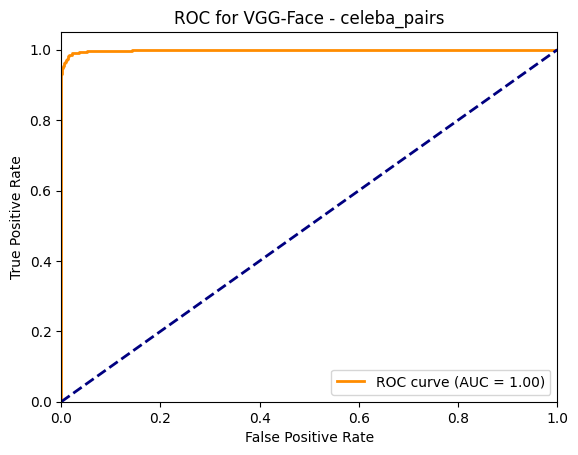

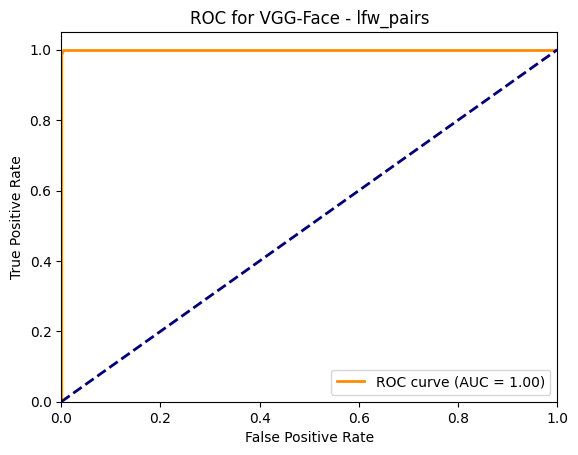

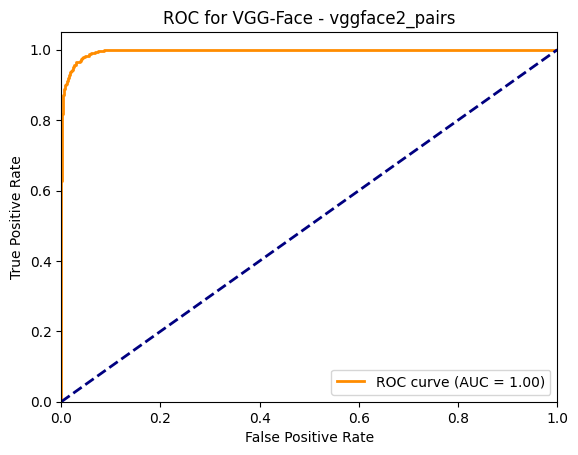

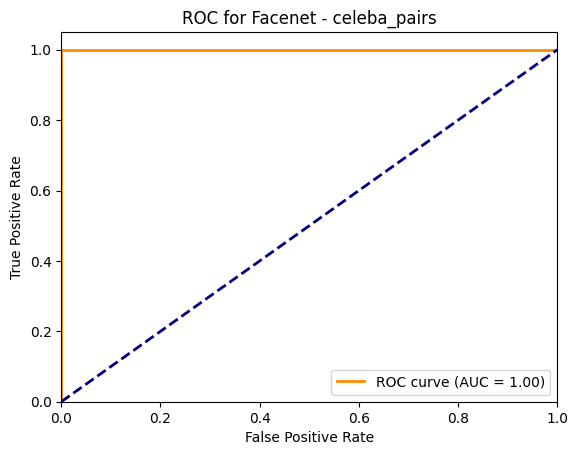

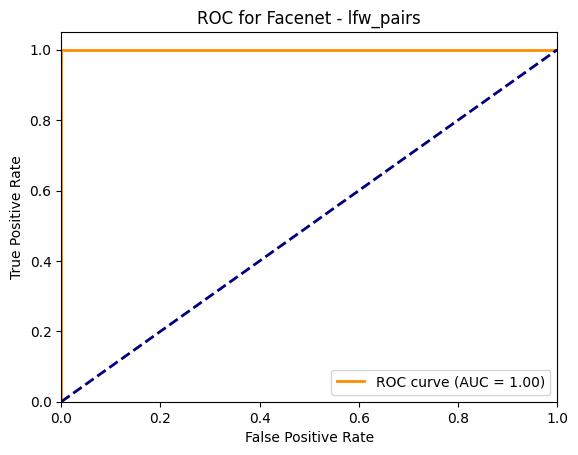

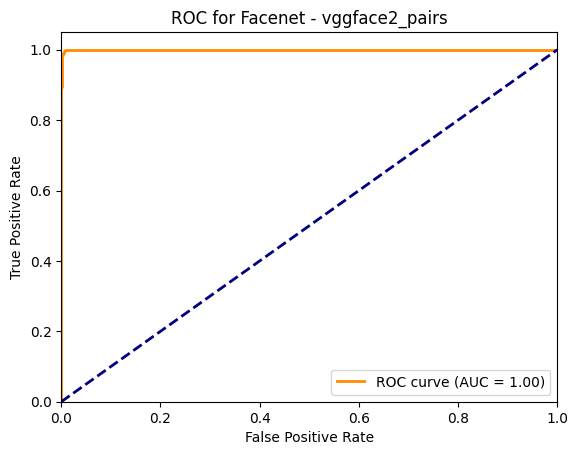

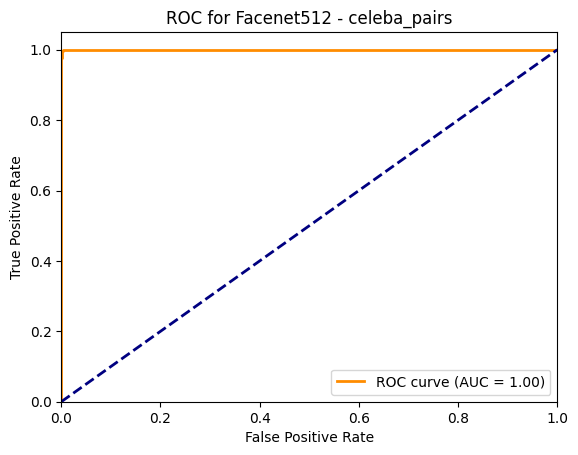

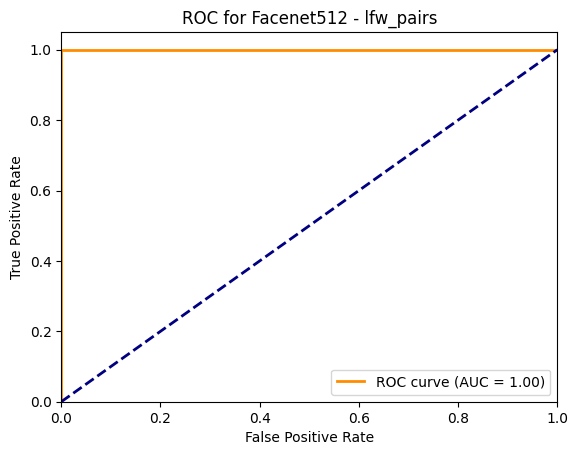

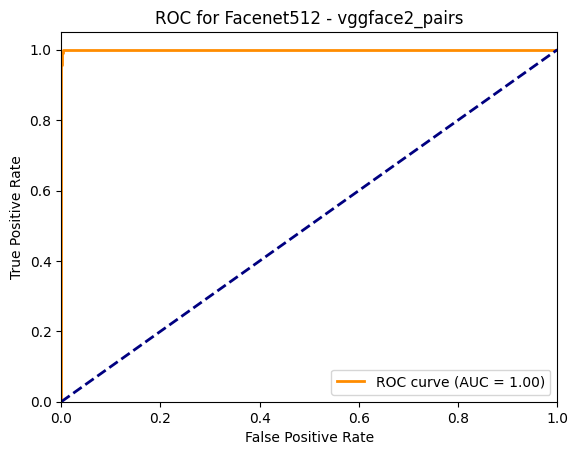

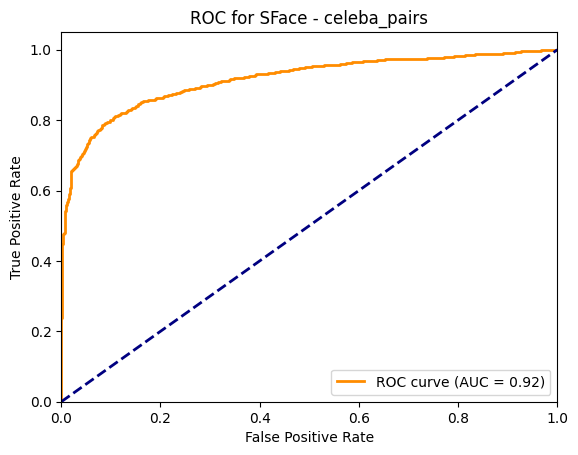

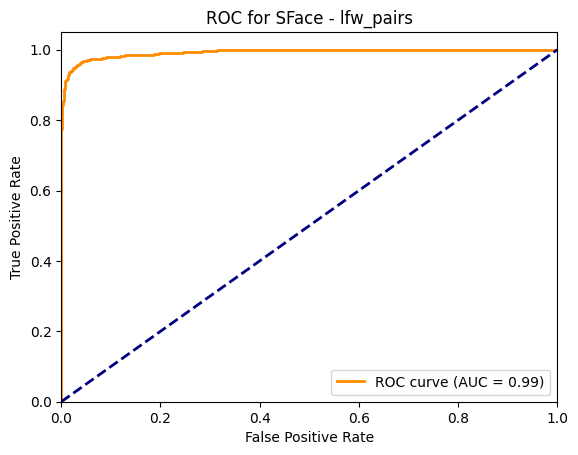

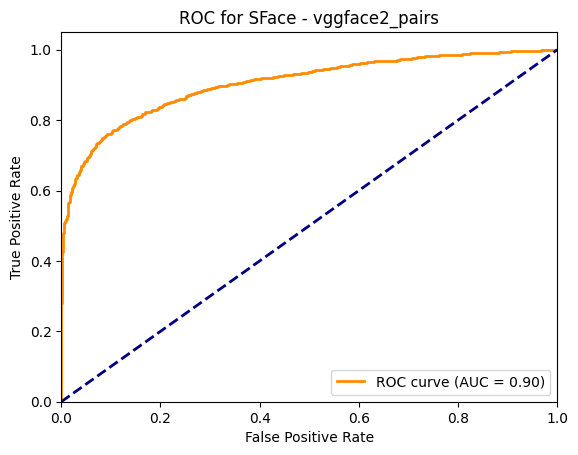

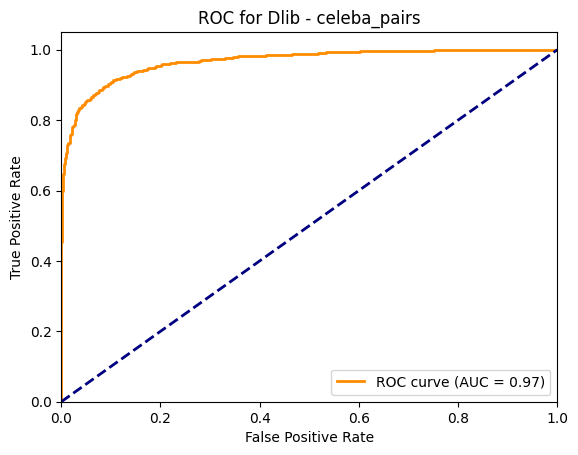

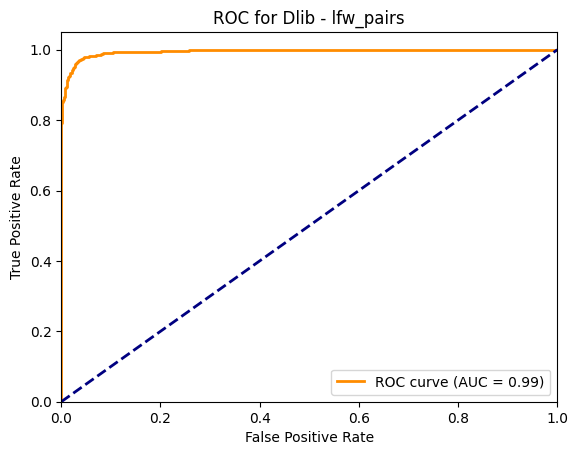

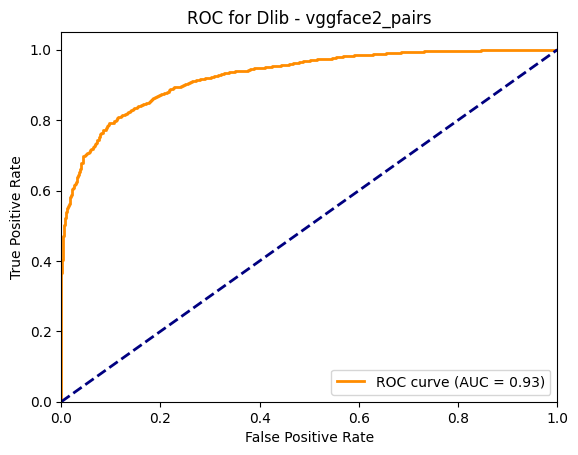

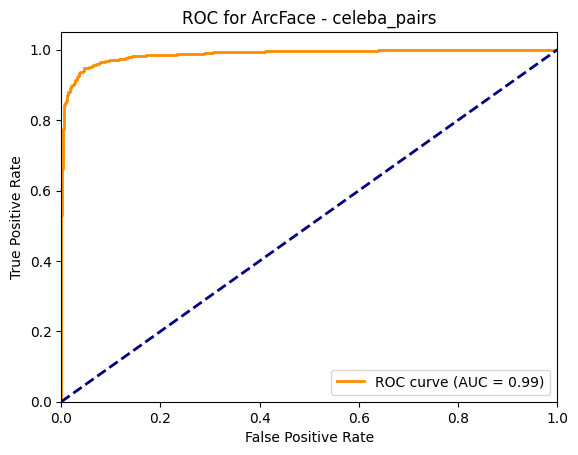

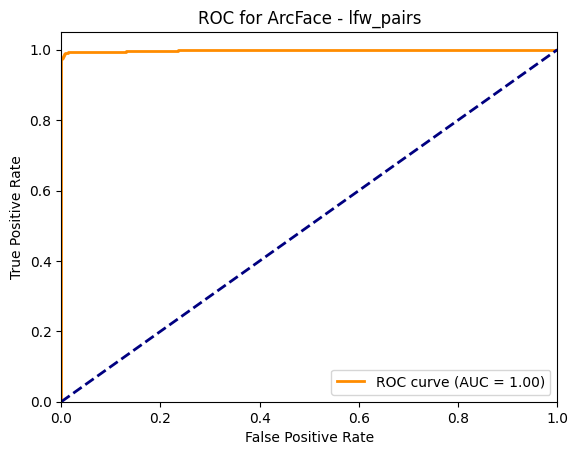

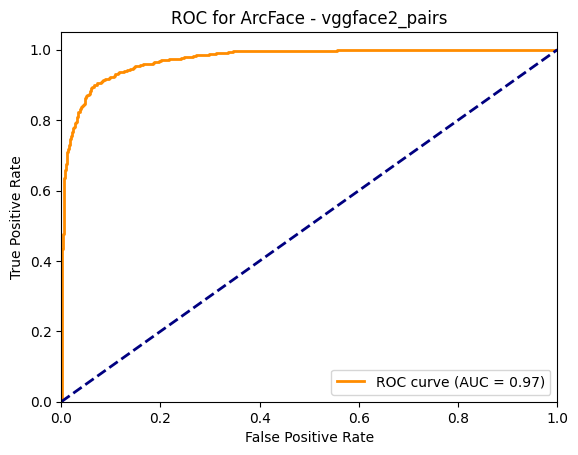

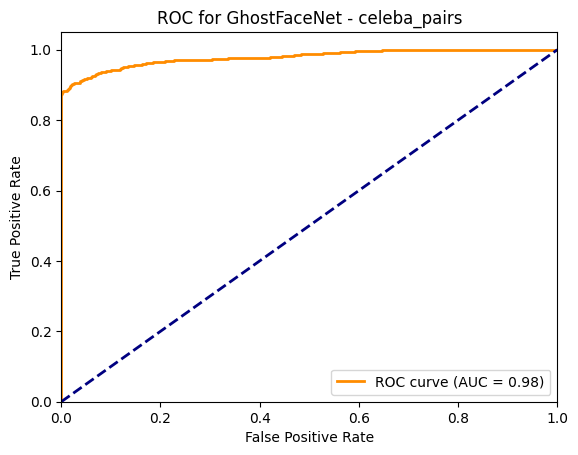

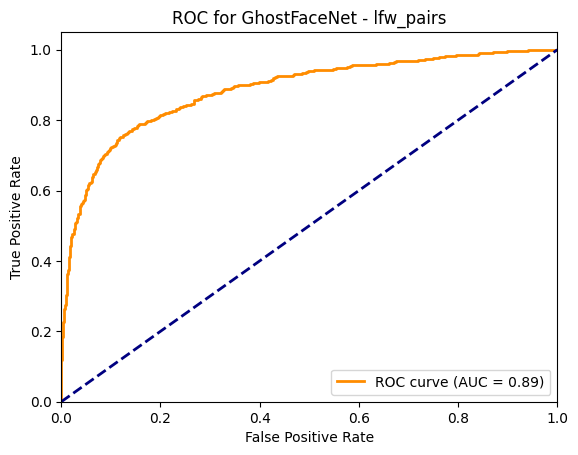

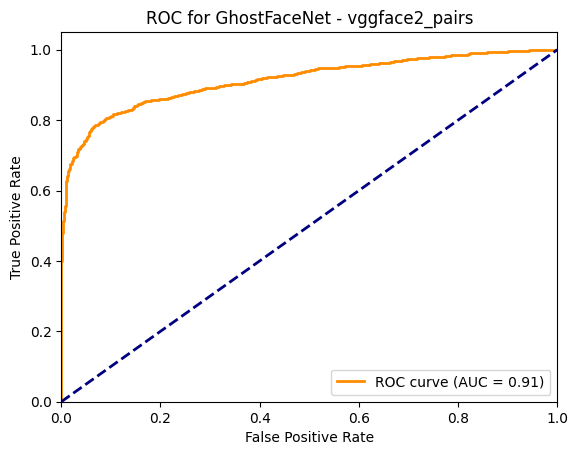

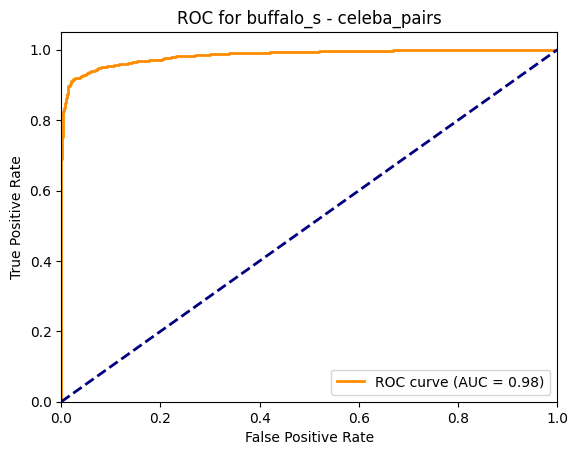

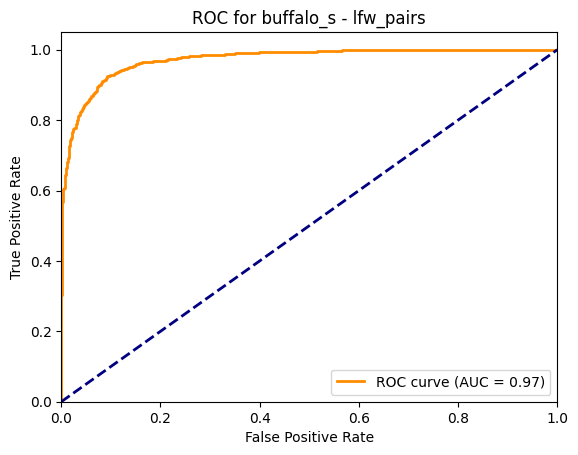

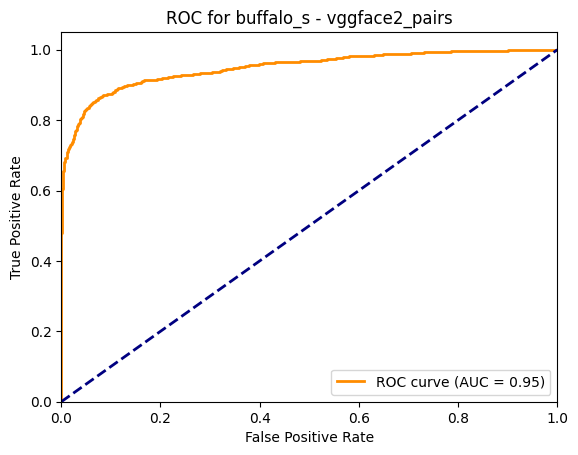

Processing complete!
Final thresholds saved to thresholds_name.json (using EER method)
Method comparison saved to threshold_methods_comparison.csv
Statistics saved to method_comparison_stats.json


In [5]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve, auc, accuracy_score
import json
import matplotlib.pyplot as plt
import warnings
from sklearn.exceptions import UndefinedMetricWarning

def calculate_eer_threshold(y_true, y_scores):
    """Calculate Equal Error Rate (EER) threshold"""
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=UndefinedMetricWarning)
        try:
            fpr, tpr, thresholds = roc_curve(y_true, y_scores)
            fnr = 1 - tpr
            diff = np.absolute(fnr - fpr)
            if np.all(np.isnan(diff)):
                return None, None
            eer_idx = np.nanargmin(diff)
            return thresholds[eer_idx], fpr[eer_idx]
        except ValueError:
            return None, None

def calculate_max_accuracy_threshold(y_true, y_scores):
    """Calculate threshold that maximizes accuracy"""
    thresholds = np.arange(0, 1, 0.001)
    accuracies = []
    for thresh in thresholds:
        y_pred = (y_scores >= thresh).astype(int)
        accuracies.append(accuracy_score(y_true, y_pred))

    max_acc_idx = np.argmax(accuracies)
    return thresholds[max_acc_idx], accuracies[max_acc_idx]

def calculate_roc_auc_threshold(y_true, y_scores):
    """Calculate ROC curve and find optimal threshold"""
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    # Youden's J statistic to find optimal threshold
    youden_j = tpr - fpr
    optimal_idx = np.argmax(youden_j)
    return thresholds[optimal_idx], roc_auc

def plot_roc_curve(y_true, y_scores, model_name, dataset_name):
    """Plot ROC curve for visualization"""
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2,
             label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC for {model_name} - {dataset_name}')
    plt.legend(loc="lower right")
    plt.show()

def evaluate_all_methods(y_true, y_scores):
    """Evaluate all three methods and return results"""
    results = {}

    # EER Method
    eer_thresh, eer_fpr = calculate_eer_threshold(y_true, y_scores)
    results['EER'] = {
        'threshold': round(eer_thresh, 4) if eer_thresh is not None else None,
        'FPR': round(eer_fpr, 4) if eer_fpr is not None else None,
        'FRR': round(1 - eer_fpr, 4) if eer_fpr is not None else None
    }

    # Max Accuracy Method
    acc_thresh, acc_value = calculate_max_accuracy_threshold(y_true, y_scores)
    results['MaxAccuracy'] = {
        'threshold': round(acc_thresh, 4),
        'accuracy': round(acc_value, 4)
    }

    # ROC/AUC Method
    roc_thresh, roc_auc = calculate_roc_auc_threshold(y_true, y_scores)
    results['ROCAUC'] = {
        'threshold': round(roc_thresh, 4),
        'AUC': round(roc_auc, 4)
    }

    return results

def main():
    # Read the cosine similarities file
    df = pd.read_csv('cosine_original_similarities.csv')

    # Define models and datasets
    models = ['VGG-Face', 'Facenet', 'Facenet512', 'SFace',
              'Dlib', 'ArcFace', 'GhostFaceNet', 'buffalo_s']
    datasets = df['dataset'].unique()

    # Initialize results storage
    all_results = {}
    final_thresholds = {model: {} for model in models}
    method_comparison = []

    # Process each model and dataset combination
    for model in models:
        for dataset in datasets:
            # Filter data for current dataset and model
            subset = df[(df['dataset'] == dataset) & (~df['attack_type'].isna())]

            if len(subset) == 0:
                print(f"⚠️ No attack pairs for {model} - {dataset}")
                continue

            # Create binary labels (1 for dodging, 0 for impersonation)
            y_true = np.where(subset['attack_type'] == 'dodging_attack', 1, 0)
            y_scores = subset[model].values

            if len(np.unique(y_true)) < 2:
                print(f"⚠️ Only one attack type for {model} - {dataset}")
                continue

            # Evaluate all methods
            results = evaluate_all_methods(y_true, y_scores)
            all_results[f"{model}_{dataset}"] = results

            # Plot ROC curve (optional - can comment out to skip plots)
            plot_roc_curve(y_true, y_scores, model, dataset)

            # Select best method (here we choose EER as it's standard for biometrics)
            selected_threshold = results['EER']['threshold']
            final_thresholds[model][dataset] = selected_threshold

            # Store method comparison data
            method_comparison.append({
                'model': model,
                'dataset': dataset,
                'EER_threshold': results['EER']['threshold'],
                'MaxAccuracy_threshold': results['MaxAccuracy']['threshold'],
                'ROCAUC_threshold': results['ROCAUC']['threshold'],
                'EER_FPR': results['EER']['FPR'],
                'MaxAccuracy': results['MaxAccuracy']['accuracy'],
                'AUC': results['ROCAUC']['AUC']
            })

    # Save final thresholds (using EER method)
    with open('thresholds_name1.json', 'w') as f:
        json.dump(final_thresholds, f, indent=2)

    # Save method comparison report
    comparison_df = pd.DataFrame(method_comparison)
    comparison_df.to_csv('threshold_methods_comparison.csv', index=False)

    # Generate method comparison statistics
    stats = {
        'Average_FPR_EER': comparison_df['EER_FPR'].mean(),
        'Average_Accuracy_MaxAccuracy': comparison_df['MaxAccuracy'].mean(),
        'Average_AUC': comparison_df['AUC'].mean(),
        'Threshold_Variation': {
            'EER_vs_MaxAcc': (comparison_df['EER_threshold'] - comparison_df['MaxAccuracy_threshold']).abs().mean(),
            'EER_vs_ROCAUC': (comparison_df['EER_threshold'] - comparison_df['ROCAUC_threshold']).abs().mean()
        }
    }

    with open('method_comparison_stats.json', 'w') as f:
        json.dump(stats, f, indent=2)

    print("Processing complete!")
    print("Final thresholds saved to thresholds_name.json (using EER method)")
    print("Method comparison saved to threshold_methods_comparison.csv")
    print("Statistics saved to method_comparison_stats.json")

if __name__ == "__main__":
    main()